In [162]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

data = load_data("../stats/fpm_2_open_solver_1.json")

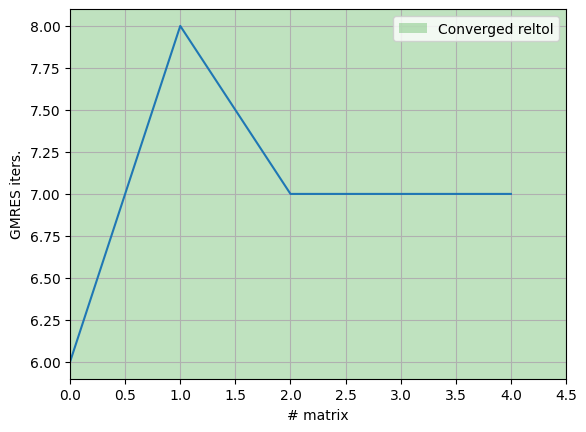

In [163]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [164]:
mat_idx = 3
get_gmres_iterations(data)[mat_idx]

7

In [165]:
from plot_utils import *

mat, rhs = load_matrix_rhs(data, mat_idx)

In [166]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_2 import make_model
from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)
mat = mat[reorder]

# model.assemble_linear_system()
# mat, rhs = model.linear_system
model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

Solve  took: 0.1


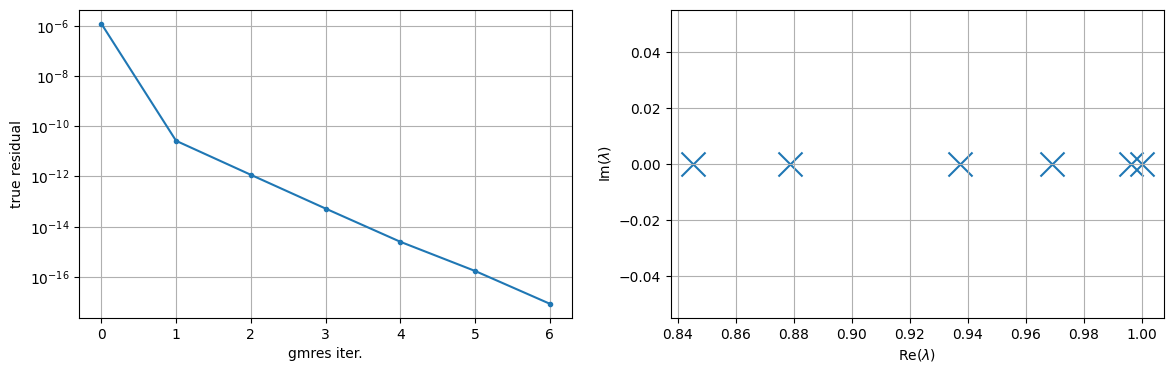

In [167]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

In [168]:
def correct_eq_groups(model):
    """We reindex eq_dofs and model._equation_groups to put together normal and tangential components of the contact equation for each dof."""
    eq_dofs_corrected = [x.copy() for x in model.eq_dofs]
    eq_groups_corrected = [x.copy() for x in model._equation_groups]

    end_normal = len(model._equation_groups[4]) // 2
    normal_subgroups = model._equation_groups[4][:end_normal]

    eq_dofs_corrected = []
    for i, x in enumerate(model.eq_dofs):
        if i not in model._equation_groups[4]:
            eq_dofs_corrected.append(x)
        else:
            if i in normal_subgroups:
                eq_dofs_corrected.append(None)

    i = model.eq_dofs[normal_subgroups[0]][0]
    for normal in normal_subgroups:
        res = i + np.arange(model.eq_dofs[normal].size * model.nd)
        i = res[-1] + 1
        eq_dofs_corrected[normal] = np.array(res)

    eq_groups_corrected[4] = normal_subgroups
    eq_groups_corrected[5] = (
        np.array(model._equation_groups[5]) - end_normal
    ).tolist()

    return eq_dofs_corrected, eq_groups_corrected

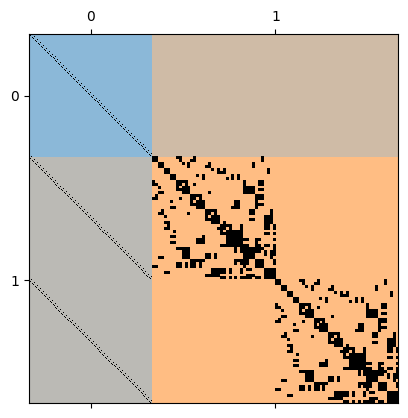

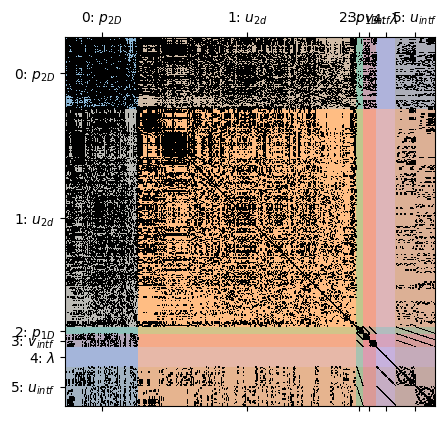

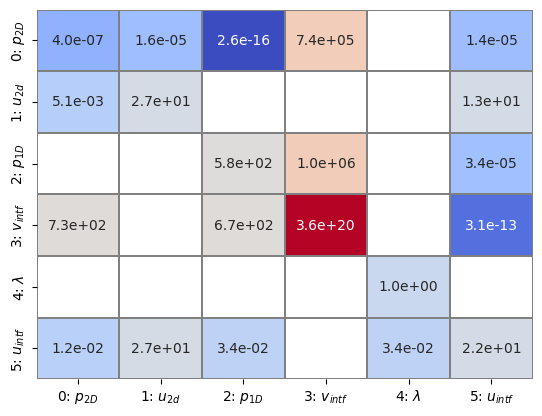

In [169]:
from block_matrix import BlockMatrixStorage

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)

J = BlockMatrixStorage(
    mat=mat,
    row_idx=corrected_eq_dofs,
    col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    group_col_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
)

J[[4, 5]].color_spy(False)

J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

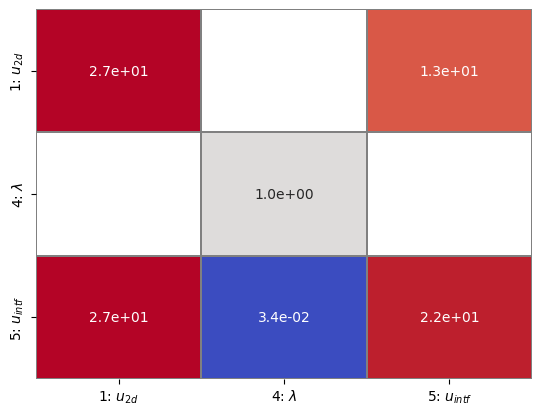

In [170]:
J_mech = J[[1,4,5]]
J_mech.plot_max()


Solve  took: 0.02


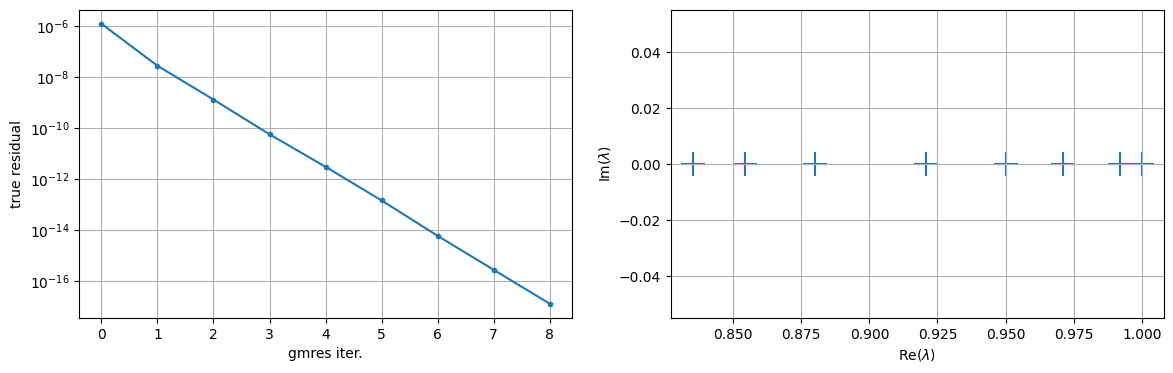

In [171]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization

schema_1 = SolveSchema(
    groups=[1],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema_45_1 = SolveSchema(
    groups=[4, 5],
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

/home/porepy/simulations/plot_utils.py:101: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


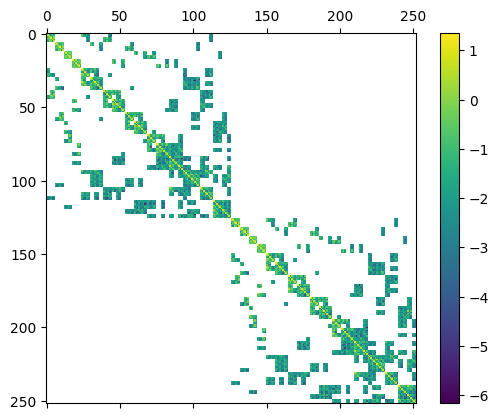

In [172]:
# J_mech[[5]].color_spy()
J_mech[[5]].matshow()

Solve  took: 0.0


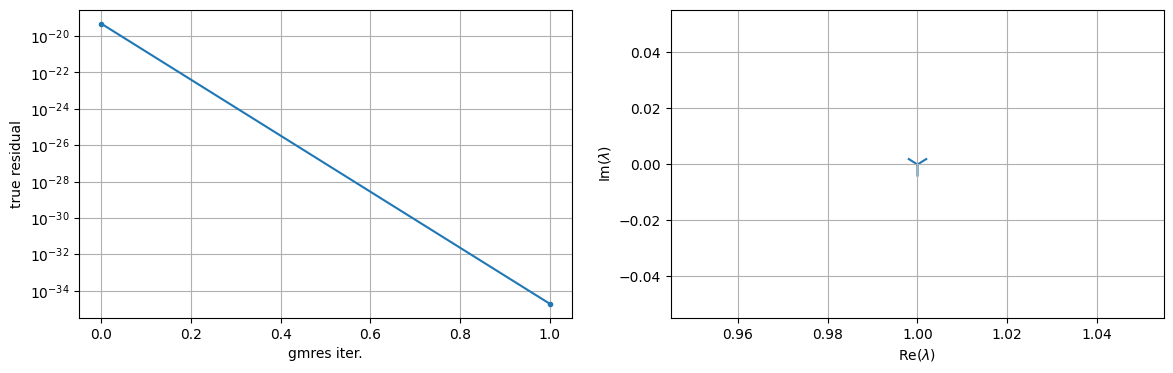

In [173]:
schema_5_4 = SolveSchema(
    groups=[5],
    # solve='direct',
    invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(abs(bmat.mat)) / 6,

    complement=SolveSchema(
        groups=[4],
        # solve=lambda bmat: inv_block_diag_2x2(bmat.mat),
    )
)

mat_permuted, prec = make_solver(schema=schema_5_4, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Note: It's not good enough to just take a diagonal approximation of J55

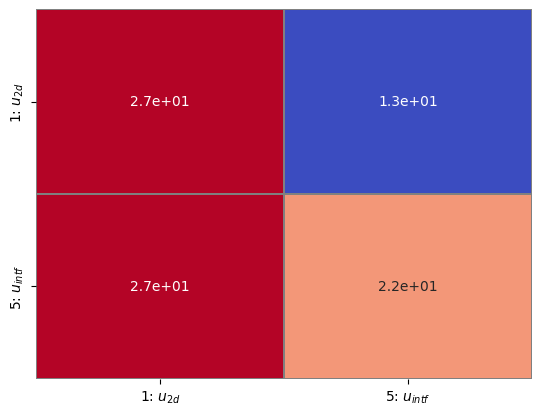

In [174]:
J[[1, 5]].plot_max()

Solve  took: 0.05


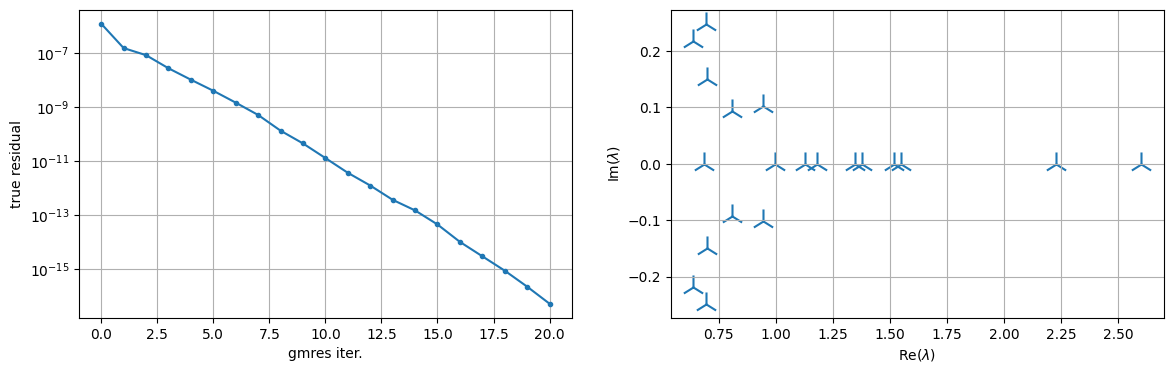

In [175]:
schema_5_4_1 = SolveSchema(
    groups=[5],
    solve='direct',
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(bmat.mat),
    invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
    # invertor=lambda bmat: inv_lu(bmat.mat),

    complement=SolveSchema(
        groups=[4],
        # solve=lambda bmat: inv_block_diag_2x2(bmat.mat[reorder])[:, reorder_inv],

        complement=schema_1,
    ),
    # complement=schema_1
)

mat_permuted, prec = make_solver(schema=schema_5_4_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

(ABOVE SHOULD FAIL)

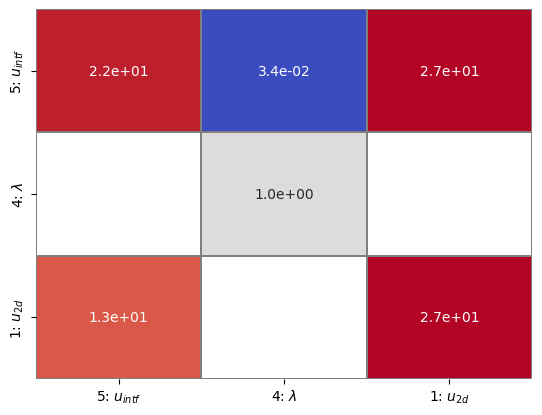

In [176]:
mat_permuted.plot_max()

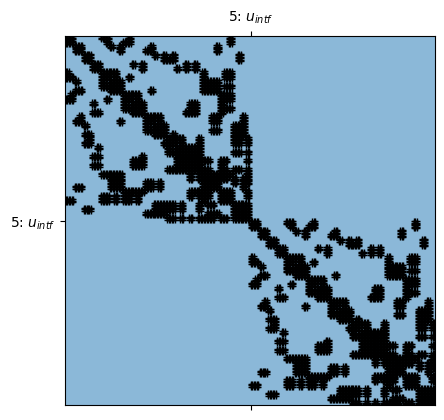

In [177]:
J[[5]].color_spy()

/home/porepy/simulations/plot_utils.py:101: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


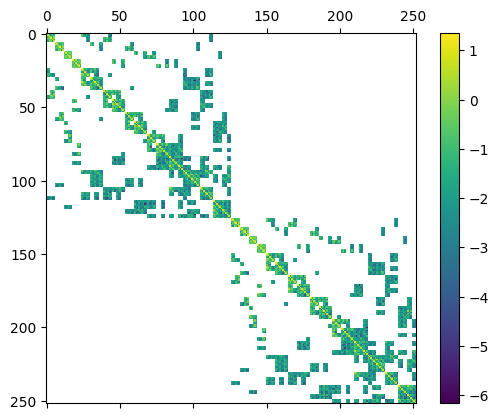

In [178]:
J[[5]].matshow()

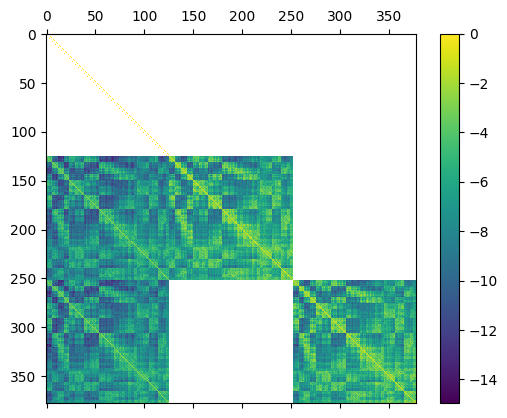

In [179]:
plot_mat(inv(J[[4,5]].mat))

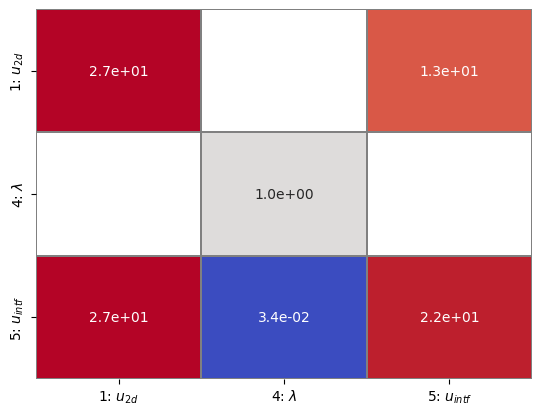

In [180]:
J_mech.plot_max()

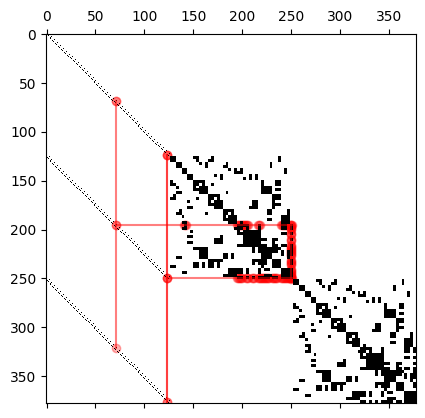

In [181]:
# %matplotlib tk


tmp = J_mech[[4, 5]].mat
spy(tmp, show=False)

row_start = 250
col_start = 250
recursion = 4

def connect_vertices(mat, mat_t, row_start, col_start, recursion=1, transposed=False):
    if recursion == 0:
        return
    
    mat_t = mat_t.tocsr()
    mat = mat.tocsr()    
    cols = mat[row_start].indices
    if not transposed:
        plt.plot([min(cols), max(cols)], [row_start, row_start], alpha=0.5, color='red')
        plt.scatter(cols, [row_start] * len(cols), color='red', alpha=0.3)
    else:
        plt.plot([row_start, row_start], [min(cols), max(cols)], alpha=0.5, color='red')
        plt.scatter([row_start] * len(cols), cols, color='red', alpha=0.3)

    col = cols[np.argmax(abs(cols - col_start))]
    connect_vertices(mat_t, mat, row_start=col, col_start=row_start, recursion=recursion-1, transposed=not transposed)

connect_vertices(tmp, tmp.T, row_start=row_start, col_start=col_start, recursion=recursion)
connect_vertices(tmp.T, tmp, row_start=col_start, col_start=row_start, recursion=recursion, transposed=True)

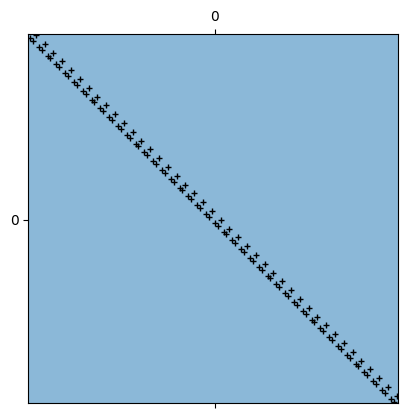

In [182]:
J[[4]].color_spy(False)

3d problem with 1 fracture?
Scalable?
Lumping
what I proposed

In [183]:
matrix = model.mdg.subdomains()[0]
fracture = model.mdg.subdomains()[1]
intf = model.mdg.interfaces()[0]

secondary_to_mortar = intf.secondary_to_mortar_avg(nd=1).tocsc()
mortar_to_primary = intf.mortar_to_primary_avg(nd=1).tocsc()
faces_to_cells = matrix.cell_faces.T.tocsc()

secondary_to_mortar.eliminate_zeros()
mortar_to_primary.eliminate_zeros()
faces_to_cells.eliminate_zeros()

frac_cells = [1]
intf_cells = secondary_to_mortar[:, frac_cells].indices
print(f'{intf_cells = }')
mat_faces = mortar_to_primary[:, intf_cells].indices
print(f'{mat_faces = }')
mat_cells = faces_to_cells[:, mat_faces].indices
print(f'{mat_cells = }')

intf_cells = array([ 1, 43], dtype=int32)
mat_faces = array([   5, 1062], dtype=int32)
mat_cells = array([421, 447], dtype=int32)


In [184]:
from porepy.numerics.linalg.matrix_operations import sparse_array_to_row_col_data, sparse_kronecker_product


secondary_to_mortar = intf.secondary_to_mortar_avg(nd=model.nd).tocsc()
mortar_to_primary = intf.mortar_to_primary_avg(nd=model.nd).tocsc()
faces_to_cells = sparse_kronecker_product(matrix.cell_faces.T, nd=model.nd).tocsc()

secondary_to_mortar.eliminate_zeros()
mortar_to_primary.eliminate_zeros()
faces_to_cells.eliminate_zeros()

frac_cells = [0, 1]
intf_cells = secondary_to_mortar[:, frac_cells].indices
print(f'{intf_cells = }')
mat_faces = mortar_to_primary[:, intf_cells].indices
print(f'{mat_faces = }')
mat_cells = faces_to_cells[:, mat_faces].indices
print(f'{mat_cells = }')

frac_to_mat_cells = faces_to_cells @ mortar_to_primary @ secondary_to_mortar

intf_cells = array([  0, 126,   1, 127], dtype=int32)
mat_faces = array([   6, 3183,    7, 3184], dtype=int32)
mat_cells = array([1236, 1239, 1237, 1240], dtype=int32)


In [185]:
# fracture.get_internal_nodes()

intfs = model.mdg.subdomain_to_interfaces(fracture)
intf = intfs[0]
model.mdg.interface_to_subdomain_pair(intf=intf)[0]

Grid history: Compute geometry
Number of cells 465
Number of faces 1103
Number of nodes 186
Dimension 3

In [186]:
def build_local_stabilization(
    bmat: BlockMatrixStorage,
    frac_cells,
    intf_cells,
    mat_cells,
    frac_idx,
    build_schur=True,
):
    j44 = bmat.slice_submatrix(
        local_indices=(frac_cells, frac_cells),
        group=(4, 4),
        subgroup=(frac_idx, frac_idx),
    ).toarray()
    j55 = bmat.slice_submatrix(
        local_indices=(intf_cells, intf_cells),
        group=(5, 5),
        subgroup=(frac_idx, frac_idx),
    ).toarray()
    j45 = bmat.slice_submatrix(
        local_indices=(frac_cells, intf_cells),
        group=(4, 5),
        subgroup=(frac_idx, frac_idx),
    ).toarray()
    j54 = bmat.slice_submatrix(
        local_indices=(intf_cells, frac_cells),
        group=(5, 4),
        subgroup=(frac_idx, frac_idx),
    ).toarray()

    j_local = np.block(
        [
            [j44, j45],
            [j54, j55],
        ]
    )

    j_local_inv = np.linalg.inv(j_local)
    if not build_schur:
        return j_local_inv

    j_vert = bmat.slice_submatrix(
        local_indices=(mat_cells, intf_cells), group=(1, 5), subgroup=(0, frac_idx)
    ).toarray()
    j_hor = bmat.slice_submatrix(
        local_indices=(intf_cells, mat_cells), group=(5, 1), subgroup=(frac_idx, 0)
    ).toarray()
    return -j_vert @ j_local_inv[model.nd :, model.nd :] @ j_hor


def build_mechanics_stabilization(bmat: BlockMatrixStorage, build_schur=True):
    shape = bmat[[1]].shape if build_schur else bmat[[4, 5]].shape
    result = scipy.sparse.lil_matrix(shape)

    fractures = model.mdg.subdomains(dim=model.nd - 1)

    for frac_idx, frac in enumerate(fractures):
        intfs = model.mdg.subdomain_to_interfaces(sd=frac)
        for intf in intfs:
            if intf.dim < frac.dim:
                continue
            matrix = model.mdg.interface_to_subdomain_pair(intf=intf)[0]
            assert matrix.dim == model.nd

            secondary_to_mortar = intf.secondary_to_mortar_avg(nd=model.nd).tocsc()
            mortar_to_primary = intf.mortar_to_primary_avg(nd=model.nd).tocsc()
            faces_to_cells = sparse_kronecker_product(
                matrix.cell_faces.T, nd=model.nd
            ).tocsc()
            secondary_to_mortar.eliminate_zeros()
            mortar_to_primary.eliminate_zeros()
            faces_to_cells.eliminate_zeros()

            frac_to_mat_cells = faces_to_cells @ mortar_to_primary @ secondary_to_mortar

            for frac_cell_id in range(frac.num_cells):
                frac_cells = frac_cell_id * model.nd + np.arange(model.nd)
                intf_cells = secondary_to_mortar[:, frac_cells].indices
                mat_cells = frac_to_mat_cells[:, frac_cells].indices

                if build_schur:
                    global_i = global_j = mat_cells
                else:
                    j44 = bmat[[4]]
                    frac_cells_offset = j44.get_global_indices(
                        local_indices=(frac_cells, frac_cells),
                        group=(4, 4),
                        subgroup=(frac_idx, frac_idx),
                    )[0]
                    intf_cells_offset = bmat[[5]].get_global_indices(
                        local_indices=(intf_cells, intf_cells),
                        group=(5, 5),
                        subgroup=(frac_idx, frac_idx),
                    )[0]
                    global_i = global_j = np.concatenate(
                        [frac_cells_offset, j44.shape[0] + intf_cells_offset]
                    )

                global_i, global_j = np.meshgrid(
                    global_i, global_j, copy=False, sparse=True, indexing="ij"
                )
                result[global_i, global_j] += build_local_stabilization(
                    bmat=bmat,
                    frac_cells=frac_cells,
                    intf_cells=intf_cells,
                    mat_cells=mat_cells,
                    frac_idx=frac_idx,
                    build_schur=build_schur,
                )
    return result.tocsr()

In [187]:
mech_stab = build_mechanics_stabilization(J, build_schur=False)

print(cond(J[[4, 5]].mat @ mech_stab)) # First is small
print(cond(mech_stab @ J[[4, 5]].mat)) # This is large

1.8585126535067078
2.077043919300176


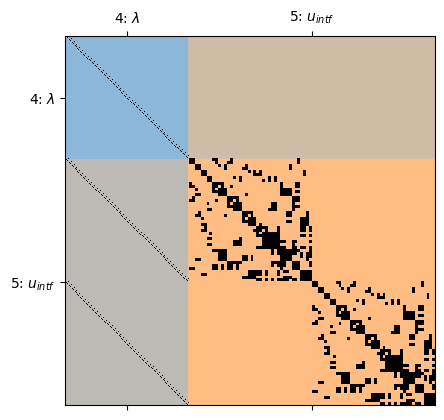

In [188]:
J[[4,5]].color_spy()

Solve  took: 0.04


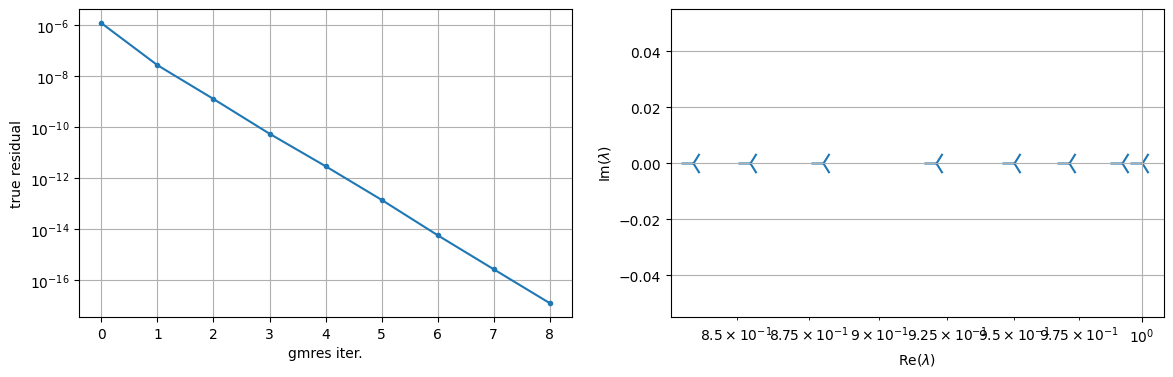

In [189]:
# Block diag inv

schema_45_1 = SolveSchema(
    groups=[5],
    solve=lambda x: x.block_diag_inv(),
    invertor=lambda x: x.block_diag_inv(),
    complement=SolveSchema(
        groups=[4],
        solve=lambda x: x.block_diag_inv(),
        invertor=lambda x: x.block_diag_inv(),
        complement=schema_1,
    )
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), logx_eigs=True)

Solve  took: 0.07


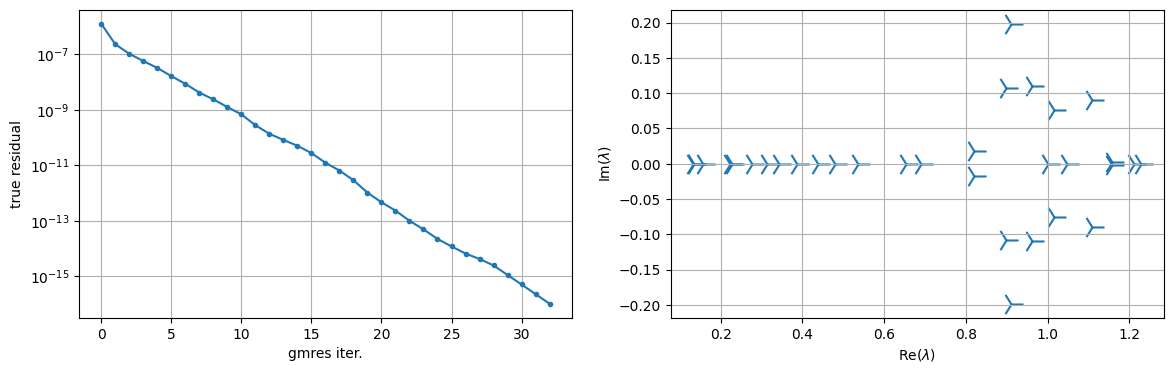

In [190]:
schema_45_1 = SolveSchema(
    groups=[4, 5],
    solve='direct',
    # invertor=lambda x: scipy.sparse.eye(x.shape[0]),

    invertor=lambda: build_mechanics_stabilization(J),
    invertor_type='physical',
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

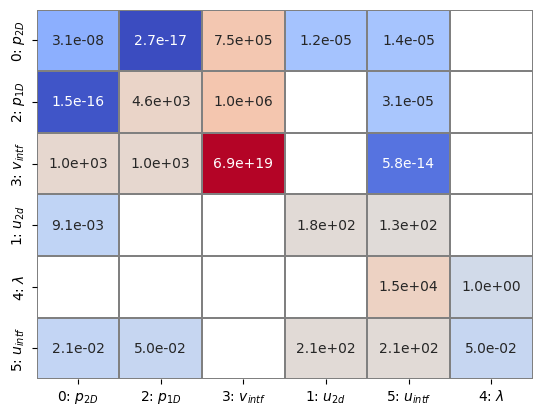

In [100]:
J.plot_max()

Solve  took: 0.0
PETSc Converged Reason: -9


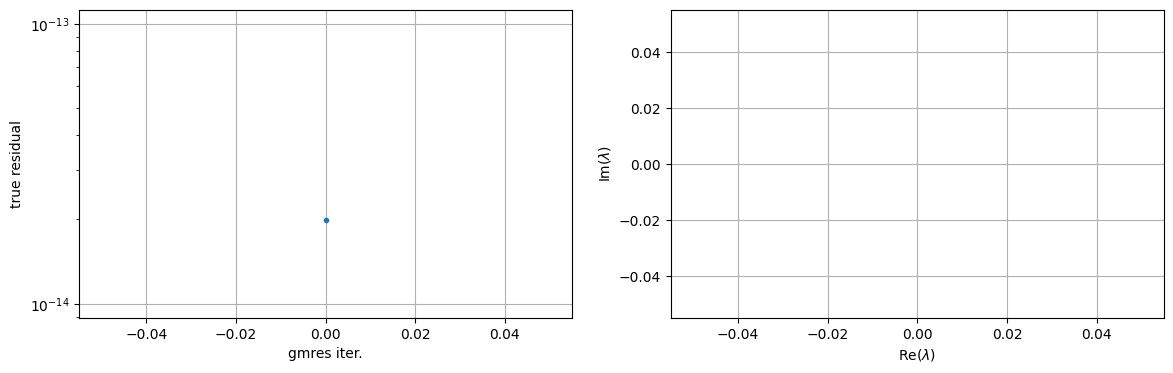

In [ ]:
schema_5_4_1 = SolveSchema(
    groups=[5],
    solve='direct',
    invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
    complement=SolveSchema(
        groups=[4],
        solve='direct',
        invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
        complement=schema_1,
    ),
)

mat_permuted, prec = make_solver(schema=schema_5_4_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

(ABOVE SHOULD FAIL)

# How to solve blocks 4 and 5 not by a direct solver?

Solve  took: 0.0


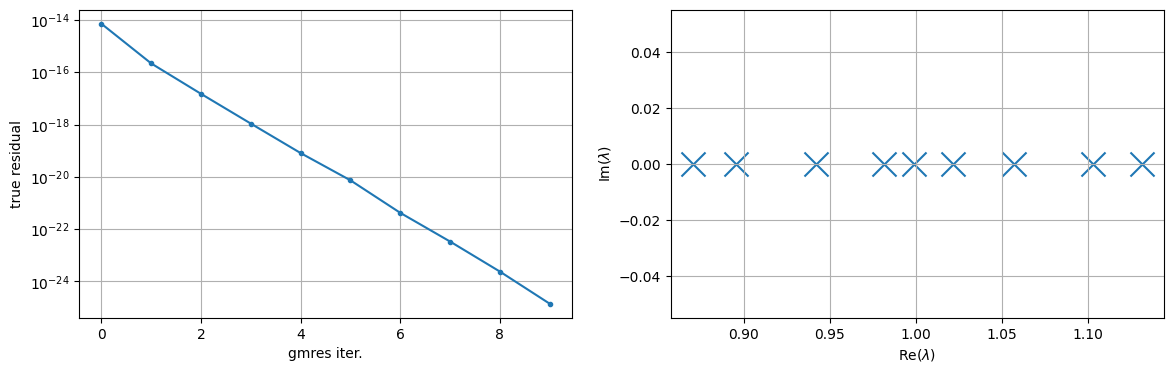

In [101]:
schema_45 = SolveSchema(
    groups=[4, 5],
    solve=lambda bmat: build_mechanics_stabilization(bmat=bmat, build_schur=False),
)

mat_permuted, prec = make_solver(schema=schema_45, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Solve  took: 0.38


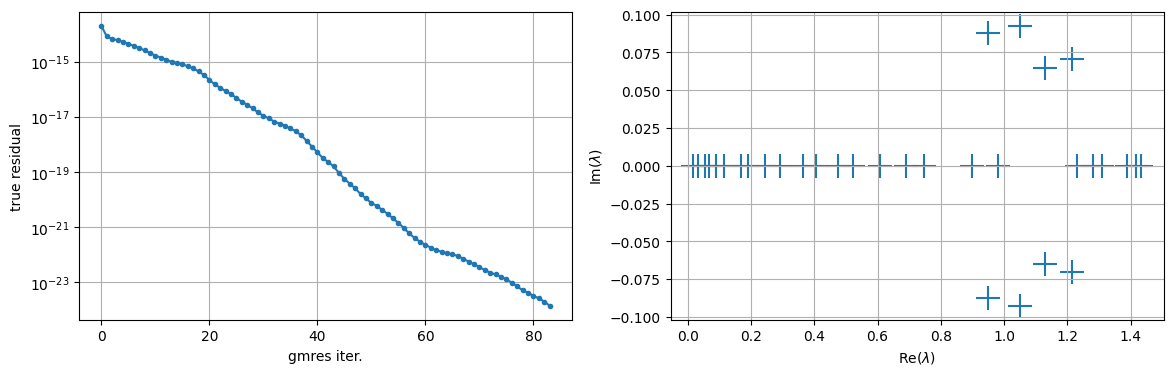

In [102]:
schema_45_1 = SolveSchema(
    groups=[4, 5],
    solve=lambda bmat: build_mechanics_stabilization(bmat=bmat, build_schur=False),
    invertor=lambda: build_mechanics_stabilization(bmat=J),
    invertor_type='physical',
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

# Full matrix

Solve  took: 1.81
PETSc Converged Reason: -5


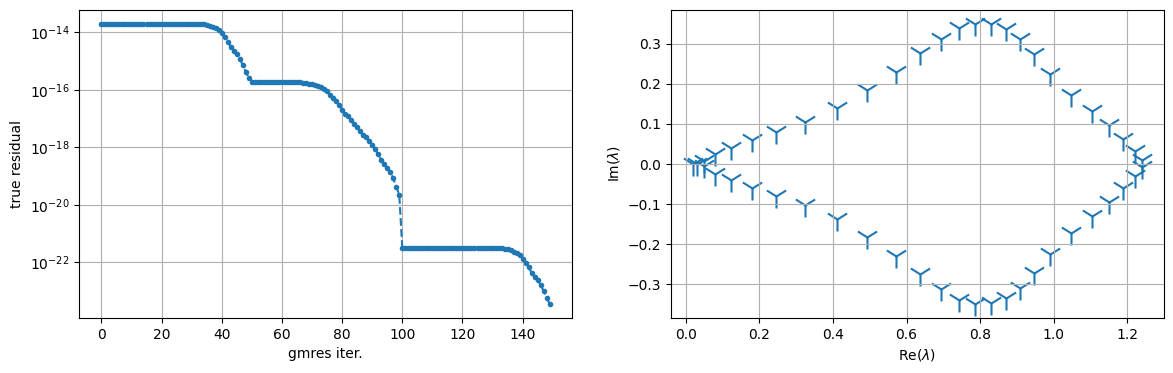

In [103]:
from pp_utils import get_fixed_stress_stabilization_nd


def fill_empty_blocks(mat):
    empty_0 = scipy.sparse.csr_matrix(J[[0]].shape)
    empty_2 = scipy.sparse.csr_matrix(J[[2]].shape)
    return scipy.sparse.block_diag(
        [
            mat,
            empty_0,
            # empty_2,
        ]
    ).tocsr()


schema_02 = SolveSchema(
    groups=[
        0,
        # 2,
    ],
    solve=lambda bmat: PetscAMGFlow(bmat.mat),
    # solve='direct'
)

solve_1_02 = SolveSchema(
    groups=[1],
    complement=schema_02,
    invertor=lambda: get_fixed_stress_stabilization(model),
    invertor_type="physical",
    # invertor='direct',
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    # solve='direct'
)

schema_45_1_02 = SolveSchema(
    groups=[4, 5],
    complement=solve_1_02,
    invertor=lambda: fill_empty_blocks(build_mechanics_stabilization(J)),
    invertor_type="physical",
    # solve=lambda bmat: build_mechanics_stabilization(build_schur=False),
    # invertor=lambda: build_mechanics_stabilization(),
)

schema_3_45_1_02 = SolveSchema(
    groups=[3],
    complement=schema_45_1_02,
    # solve=lambda bmat: PetscILU(mat=bmat.mat, factor_levels=1),
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
)

mat_permuted, prec = make_solver(schema=schema_45_1_02, mat_orig=J[[0, 1, 3, 4, 5]])
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

If we remove J22, it solves (fpm_0). So the default FS for the ambient dimension is "almost" sufficient